# Preprocessing Steps

In [ ]:
import numpy as np
import pandas as pd
import keras
import keras.utils
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
np.random.seed(0)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Load dataframes

In [ ]:
from google.colab import files
dataset_file_dict = files.upload()

Saving emoji_train.pkl to emoji_train.pkl


In [ ]:
df_train = pd.read_pickle("/content/emoji_train.pkl")      # Shape: (42627, 4)
#df_test = pd.read_pickle("source_files/emoji_test.pkl")        # (10657, 4)
df_train

,tweet,emoji_class,emoji,predicted_class
0,Brought to you courtesy of the red white and b...,5,🇺🇸,None
1,@user #taotuesday @ TAO Downtown\n,3,🔥,None
2,Ready to celebrate America with @user Happy #i...,5,🇺🇸,None
3,10min project w old footage #houstonphotograph...,2,📸,None
4,Usually I don't put song on my insta but this ...,3,🔥,None
...,...,...,...,...
42622,@user and sia__official ️ Top model @user and ...,0,❤,None
42623,"Xmas in RVA (@ The @user in Richmond, VA)\n",4,🎄,None
42624,@ The Villages on Millenia Blvd.\n,1,😂,None
42625,When all the boys wear their stars and stripes...,5,🇺🇸,None


In [ ]:
df_train

,tweet,emoji_class,emoji,predicted_class
0,Brought to you courtesy of the red white and b...,5,🇺🇸,None
1,@user #taotuesday @ TAO Downtown\n,3,🔥,None
2,Ready to celebrate America with @user Happy #i...,5,🇺🇸,None
3,10min project w old footage #houstonphotograph...,2,📸,None
4,Usually I don't put song on my insta but this ...,3,🔥,None
...,...,...,...,...
42622,@user and sia__official ️ Top model @user and ...,0,❤,None
42623,"Xmas in RVA (@ The @user in Richmond, VA)\n",4,🎄,None
42624,@ The Villages on Millenia Blvd.\n,1,😂,None
42625,When all the boys wear their stars and stripes...,5,🇺🇸,None


In [ ]:
print(len(df_train))
classes = df_train.groupby('emoji_class')
print(classes.describe())

42627
             tweet                                                            \
             count unique                                                top   
emoji_class                                                                    
0            16846  16791                     ️ @ Los Angeles, California \n   
1             7801   7784                       @ Los Angeles, California \n   
2             6103   6080                 @user @ Los Angeles, California \n   
3             4884   4868                       @ Los Angeles, California \n   
4             2450   2437  #FlockCity flockcityla // Fresh Cut High Quali...   
5             2431   2425  ALL wknd apply Code: VEGAS and receive 15% off...   
6             2112   2107                     ️ @ Los Angeles, California \n   

                  emoji                   predicted_class                   
            freq  count unique top   freq           count unique  top freq  
emoji_class                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


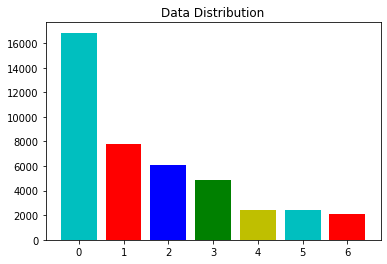

In [ ]:
plt.bar(['0', '1', '2', '3', '4', '5', '6'], height=[
                                                     df_train['emoji_class'].value_counts()[0],
                                                     df_train['emoji_class'].value_counts()[1],
                                                     df_train['emoji_class'].value_counts()[2],
                                                     df_train['emoji_class'].value_counts()[3],
                                                     df_train['emoji_class'].value_counts()[4],
                                                     df_train['emoji_class'].value_counts()[5],
                                                     df_train['emoji_class'].value_counts()[6]] , color='crbgy')
plt.title("Data Distribution")
plt.show()

## Data Preprocessing

In [ ]:
df_train.isnull().values.any()

True

In [ ]:
df_train.isnull().values

array([[False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True],
       ...,
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True]])

Feature Engineering

In [ ]:
# last column in df_train is null - we remove it
# we drop also emoji column - we don't need it
df_train = df_train.drop(columns = ["predicted_class", "emoji"])

In [ ]:
df_train.isnull().values.any()

False

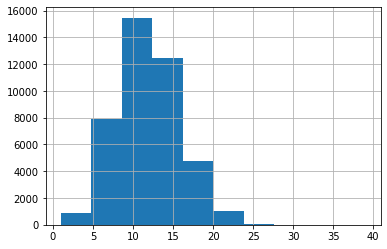

In [ ]:
#check the length distribution of tweets
df_train['tweet'].str.split().map(lambda x: len(x)).hist()

Max length -> 40 needed for padding

### Text Pre-Processing

This is rather a simple cleaning pipeline:


1.   Remove special characters and leave only letters.
2.   Lowercase all letters and split the text
3.   Remove emojis/links/usernames and normalize hash tags.
4.   Apply stemming on the data to fix the influence of the bad words
5.   Remove all the stopwords as they are do not contain a lot of information stored. 
6.   Create a sequence again

> We also make use of Stemming as we believe this might be a factor that influence the learning of the model

In [ ]:
# Reference: Code implementation for the paper "DeepHate: Hate Speech Detection via Multi-Faceted Text Representations" (WebSci'20) Roy Lee (2021) at https://gitlab.com/bottle_shop/safe/deephate/-/blob/master/DeepHate/dataset.py

In [ ]:
def expand_match(contraction):
    contraction_mapping = {
        "isn't": "is not",
        "aren't": "are not",
        "con't": "cannot",
        "can't've": "cannot have",
        "you'll've": "your will have",
        "you're": "you are",
        "you've": "you have"
    }
    match = contraction.group(0)
    first_char = match[0]
    expanded_contraction = contraction_mapping.get(match) \
        if contraction_mapping.get(match) \
        else contraction_mapping.get(match.lower())
    expanded_contraction = first_char + expanded_contraction[1:]
    return expanded_contraction

In [ ]:
def clean_tweets(text, stem_flag = False):
    url_pattern = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')
    emojis_pattern = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    hash_pattern = re.compile(r'#\w*')
    single_letter_pattern = re.compile(r'(?<![\w\-])\w(?![\w\-])')
    blank_spaces_pattern = re.compile(r'\s{2,}|\t')
    reserved_pattern = re.compile(r'(RT|rt|FAV|fav|VIA|via)')
    mention_pattern = re.compile(r'@\w*')
    CONTRACTION_MAP = {
        "isn't": "is not",
        "aren't": "are not",
        "con't": "cannot",
        "can't've": "cannot have",
        "you'll've": "your will have",
        "you're": "you are",
        "you've": "you have"
    }
    constraction_pattern = re.compile('({})'.format('|'.join(CONTRACTION_MAP.keys())),
                                        flags=re.IGNORECASE | re.DOTALL)
    Whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)
    urls = re.sub(pattern=url_pattern, repl='', string=text)
    mentions = re.sub(pattern=mention_pattern, repl='', string=urls)
    hashtag = re.sub(pattern=hash_pattern, repl='', string=mentions)
    reserved = re.sub(pattern=reserved_pattern, repl='', string=hashtag)
    reserved = Whitespace.sub(" ", reserved)
    reserved = constraction_pattern.sub(expand_match, reserved)
    punct = "[{}]+".format(string.punctuation)
    punctuation = re.sub(punct, '', reserved)
    single = re.sub(pattern=single_letter_pattern, repl='', string=punctuation)
    blank = re.sub(pattern=blank_spaces_pattern, repl=' ', string=single)
    blank = blank.lower()
    if stem_flag:
        stemming = re.sub(r'/(ies|y|ed|ing|s)(\s|\b)/g', ' ', blank)

    return blank.split() if not stem_flag else stemming.split()

In [ ]:
def tweet_processing(raw_tweet):
    words = clean_tweets(raw_tweet)
    stops = set(stopwords.words("english"))
    m_w = [w for w in words if not w in stops]
    return (" ".join(m_w))

In [ ]:
# Clean tweets
num_tweets = df_train["tweet"].size
clean_tweet = []
for i in range(0,num_tweets):
    clean_tweet.append(tweet_processing(df_train["tweet"][i]))
df_train["tweet"] = clean_tweet 

In [ ]:
df_train

,tweet,emoji_class,tokenized_sents
0,brought couesy red white blue welcome home sol...,5,"[brought, couesy, red, white, blue, welcome, h..."
1,tao downtown,3,"[tao, downtown]"
2,ready celebrate america happy columbia cafe,5,"[ready, celebrate, america, happy, columbia, c..."
3,10min project old footage the…,2,"[10min, project, old, footage, the…]"
4,usually dont put song insta shit fire thank …,3,"[usually, dont, put, song, insta, shit, fire, ..."
...,...,...,...
42622,siaofficial ️ top model video…,0,"[siaofficial, ️, top, model, video…]"
42623,xmas rva richmond va,4,"[xmas, rva, richmond, va]"
42624,villages millenia blvd,1,"[villages, millenia, blvd]"
42625,boys wear stars stripes santa monica california,5,"[boys, wear, stars, stripes, santa, monica, ca..."


## Data Preparation

Let's make the data ready for training. We need to:

- tokenize the sequence in words and assign each word in the vocabulary an index so we can relate it later on.
- pad the vectorized sequence to have fixed unit - max_length=40

In [ ]:
df_train['tokenized_sents'] = df_train.apply(lambda column: word_tokenize(column['tweet']), axis=1)

In [ ]:
def process_data(data, max_len=40):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['tokenized_sents'])
    sequences = tokenizer.texts_to_sequences(data['tokenized_sents'])
    # Pad the sequence in order to have max length...
    x = pad_sequences(sequences, maxlen=max_len)
    # Make one hot encoding for labeling part. Should be in input [1 0]
    y = to_categorical(data['emoji_class'], num_classes=7)
    # splitting the Dataset into Train and Test set
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=0, shuffle=False)
    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_validation, y_train, y_validation = process_data(df_train)

In [ ]:
x_train

array([[   0,    0,    0, ...,  382,   39, 7162],
       [   0,    0,    0, ...,    0, 4524,   87],
       [   0,    0,    0, ...,    6,  744,  263],
       ...,
       [   0,    0,    0, ...,   91,   93, 1863],
       [   0,    0,    0, ..., 2245,  134,    1],
       [   0,    0,    0, ...,   98,  330,   27]], dtype=int32)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)